Columna 'Otros' eliminada del DataFrame df_mes.


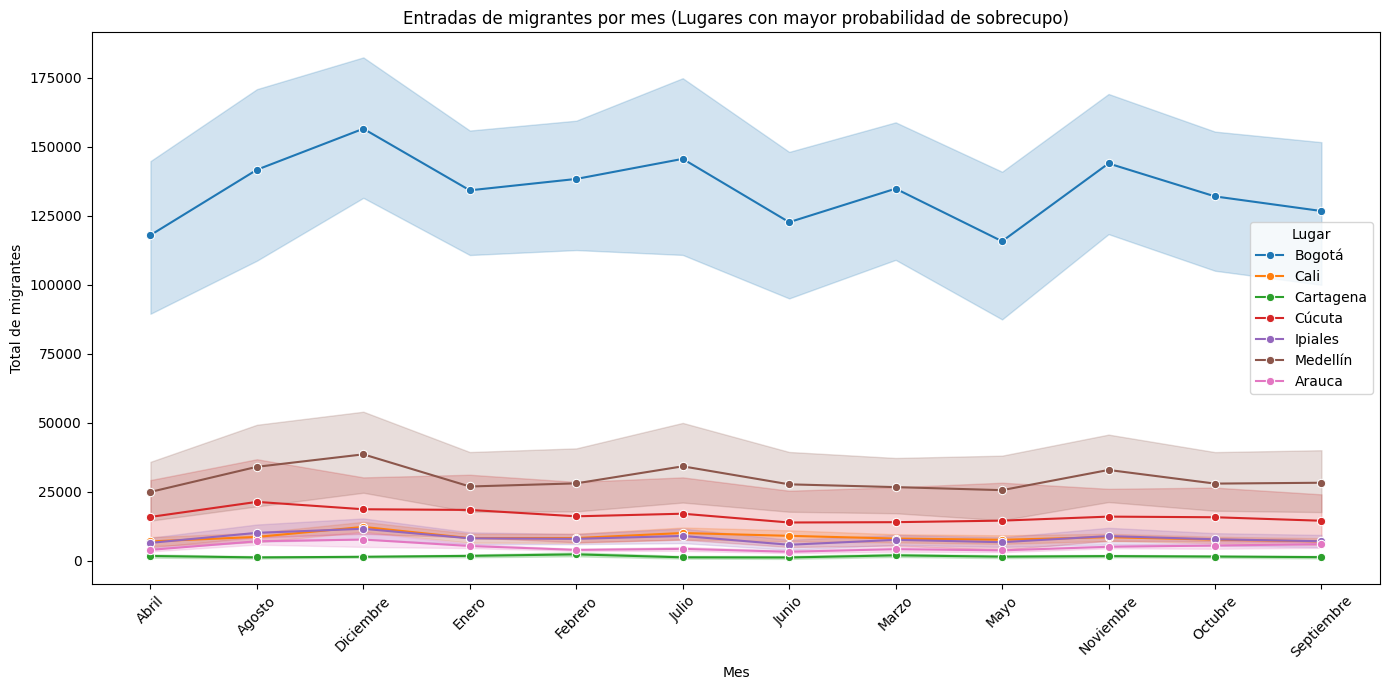


=== Estadísticas y Recomendaciones ===

Ciudad: Bogotá
  - Promedio mensual de migrantes (bootstrap): 132600.8
  - Percentil 99 (máximo esperado): 229566.0
  - Probabilidad de superar el 80% de la capacidad: 97.0%
  - Probabilidad de sobrecupo (superar el 100%): 97.0%
  🚨 ¡ALERTA CRÍTICA! Sobrecupo inminente o muy probable. Acción urgente: Implementar planes de contingencia para desviar flujos, buscar alojamientos alternativos de emergencia, coordinar apoyo humanitario adicional masivo (alimentos, salud, saneamiento), y considerar medidas de gestión de fronteras para evitar el colapso. Evaluar la posibilidad de declarar estado de emergencia si es necesario.
------------------------------------------------------------
Ciudad: Cali
  - Promedio mensual de migrantes (bootstrap): 8439.7
  - Percentil 99 (máximo esperado): 17493.0
  - Probabilidad de superar el 80% de la capacidad: 96.9%
  - Probabilidad de sobrecupo (superar el 100%): 96.9%
  🚨 ¡ALERTA CRÍTICA! Sobrecupo inminente o muy p

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cargar y limpiar el dataset
df = pd.read_csv("Entradas_de_extranjeros_a_Colombia_20250430.csv")
df['Total'] = df['Total'].astype(str).str.replace(',', '').astype(float)

# 2. Crear diccionario para cambiar las cordenadas por lugares
coordenadas_a_lugar = {
    "(4.697144,-74.140516)": "Bogotá",
    "(6.171601,-75.427454)": "Medellín",
    "(7.818934,-72.453226)": "Cúcuta",
    "(8.364293,-72.405710)": "Arauca",
    "(10.408582,-75.538003)": "Cartagena",
    "(0.814836,-77.662532)": "Ipiales",
    "(-4.197703,-69.941278)": "Leticia",
    "(3.541112,-76.384584)": "Cali"
}

def obtener_lugar(coord):
    coord = str(coord).replace(" ", "")
    return coordenadas_a_lugar.get(coord, "Otros")

df['Lugar'] = df['Latitud - Longitud'].apply(obtener_lugar)

# 3. Agrupar por año, mes y lugar
df_mes = df.groupby(['Año', 'Mes', 'Lugar'])['Total'].sum().reset_index()

# Eliminar la columna 'Otros' del DataFrame
if 'Otros' in df_mes['Lugar'].unique():
    df_mes = df_mes[df_mes['Lugar'] != 'Otros']
    print("Columna 'Otros' eliminada del DataFrame df_mes.")
else:
    print("La columna 'Otros' no existe en el DataFrame df_mes.")

# 4. Simulación bootstrap con diccionario por capacidades
n_bootstrap = 1000
umbral_alerta = 0.8

capacidades = {
    "Bogotá": 2500,
    "Medellín": 2500,
    "Cúcuta": 1200,
    "Cartagena": 1100,
    "Ipiales": 800,
    "Leticia": 600,
    "Cali": 1500,
}

resultados = []

for lugar in df_mes['Lugar'].unique():
    datos_hist = df_mes[df_mes['Lugar'] == lugar]['Total'].values
    if len(datos_hist) < 5:
        continue
    simulaciones = np.random.choice(datos_hist, size=n_bootstrap, replace=True)
    capacidad = capacidades.get(lugar, 1000)
    alertas = np.sum(simulaciones > capacidad * umbral_alerta)
    criticos = np.sum(simulaciones > capacidad)
    resultados.append({
        'Lugar': lugar,
        'Promedio_migrantes': np.mean(simulaciones),
        'P99': np.percentile(simulaciones, 99),
        'Prob_alerta_80%': alertas / n_bootstrap,
        'Prob_critico_100%': criticos / n_bootstrap
    })

df_result = pd.DataFrame(resultados)

# 5. Selección de los 7 lugares con mayor probabilidad de sobrecupo
top_lugares = df_result.sort_values('Prob_critico_100%', ascending=False).head(7)['Lugar'].tolist()

df_mes_top = df_mes[df_mes['Lugar'].isin(top_lugares)]

# 6. Gráfica
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_mes_top, x='Mes', y='Total', hue='Lugar', marker='o')
plt.title('Entradas de migrantes por mes (Lugares con mayor probabilidad de sobrecupo)')
plt.ylabel('Total de migrantes')
plt.xticks(rotation=45)
plt.legend(title='Lugar')
plt.tight_layout()
plt.show()

# 7. Mostrar recomendaciones
df_top = df_result[df_result['Lugar'].isin(top_lugares)]

print("\n=== Estadísticas y Recomendaciones ===\n")
for _, row in df_top.iterrows():
    print(f"Ciudad: {row['Lugar']}")
    print(f"  - Promedio mensual de migrantes (bootstrap): {row['Promedio_migrantes']:.1f}")
    print(f"  - Percentil 99 (máximo esperado): {row['P99']:.1f}")
    print(f"  - Probabilidad de superar el 80% de la capacidad: {row['Prob_alerta_80%']*100:.1f}%")
    print(f"  - Probabilidad de sobrecupo (superar el 100%): {row['Prob_critico_100%']*100:.1f}%")

    # Recomendaciones actualizadas
    if row['Prob_critico_100%'] > 0.2: # Probabilidad muy alta de sobrecupo (ej. > 20%)
        print("  🚨 ¡ALERTA CRÍTICA! Sobrecupo inminente o muy probable. Acción urgente: Implementar planes de contingencia para desviar flujos, buscar alojamientos alternativos de emergencia, coordinar apoyo humanitario adicional masivo (alimentos, salud, saneamiento), y considerar medidas de gestión de fronteras para evitar el colapso. Evaluar la posibilidad de declarar estado de emergencia si es necesario.")
    elif row['Prob_critico_100%'] > 0.05: # Probabilidad alta de sobrecupo (ej. entre 5% y 20%)
        print("  ⚠️ ALERTA ALTA DE SOBRECUPU: Probabilidad significativa de sobrecupo. Se recomienda: Activar protocolos de respuesta temprana, preparar recursos adicionales (personal, insumos), establecer coordinación interinstitucional para posibles derivaciones, y reforzar la comunicación con la población migrante sobre la capacidad existente y alternativas.")
    elif row['Prob_alerta_80%'] > 0.2: # Riesgo moderado de saturación (superar el 80% de la capacidad)
        print("  🔶 ALERTA MODERADA: Riesgo de saturación de capacidad. Se aconseja: Monitorear de cerca los flujos, optimizar la gestión de la gestión de los recursos actuales, establecer un plan de comunicación preventiva para informar a los migrantes, y revisar los planes de expansión de capacidad a corto plazo.")
    else:
        print("  🟢 BAJO RIESGO: Situación bajo control. Se recomienda: Mantener el monitoreo regular de los flujos, asegurar el buen funcionamiento de los servicios existentes y continuar con la planificación a largo plazo para futuras necesidades de capacidad.")
    print("-" * 60)

